# 프로젝트: KoChatGPT 업그레이드 하기
KoChatGPT 소스코드를 바탕으로 다양한 모델 개선 전략을 선택해 KoChatGPT를 업그레이드해 본다.  
제시된 전략 중 하나를 선택하거나 여러 개를 조합하여 custom ChatGPT를 개발

평가문항
1. 기존 KoGPT2와 SFT 적용 모델 결과 분석했는가?
    - 기존 모델의 결과물과 SFT를 적용한 모델의 결과물을 정량/정성적으로 비교/분석했다.
2. SFT 모델과 RM 모델 결과 분석을 해보았는가?	
    - SFT를 적용한 모델의 결과물과 RM을 적용한 모델의 결과물을 정량/정성적으로 비교/분석했다.
3. 데이터셋 정제 / 새로운 데이터셋 / foundation model 교체 중 하나를 이용해 정량적 성능 향상을 해보았는가?	
    - 기존 데이터셋을 추가로 정제하고, generation 성능을 올리기 위한 기법(Beam search, Top-k sampling 등)을 실험해 모델 성능을 향상시켰다.
    - 새로운 데이터를 수집해 전처리를 수행하여 모델의 성능을 향상시켰다.
    - 더 적절한 학습 전략(SFT, RM, PPO)을 적용하거나 initial model을 변경해 모델의 성능을 향상시켰다.

#### Setup
```python
!pip uninstall torch -y
!pip install torch==1.13.1+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

# for transformers, 최신버전은 에러발생
!pip install transformers==4.35.2
!pip install accelerate==0.24.1

# for ColossalAI
!pip install colossalai==0.2.7

# setup data
!git clone https://github.com/airobotlab/KoChatGPT
!mv KoChatGPT/data_kochatgpt .
!mv KoChatGPT/img .

%cd KoChatGPT/colossalai_ChatGPT_230319/
!pip install .
%cd ../../

# setup library
!pip install openai
!pip install langchain==0.0.113
!pip install pandas>=1.4.1
```

In [1]:
import torch
import transformers

print("Torch version:{}".format(torch.__version__))
print("Cuda version: {}".format(torch.version.cuda))
print("transformers version: {}".format(transformers.__version__))
print("cudnn version:{}".format(torch.backends.cudnn.version()))
print("GPU 사용 가능여부: {}".format(torch.cuda.is_available()))

Torch version:1.12.1
Cuda version: 11.3
transformers version: 4.28.0
cudnn version:8302
GPU 사용 가능여부: True


## 기존 데이터셋 추가 정제

data_kochatgpt 폴더  
- kochatgpt_1_SFT.jsonl : SFT를 위한 prompt와 completion 문장셋
    - prompt: 모델이 응답을 생성하기 위해 받는 입력 문장
    - completion: 해당 "prompt"에 대한 올바른 응답 또는 완성 문장
- kochatgpt_1_RM.jsonl : RM 학습을 위한 prompt와 세 가지 ranking 문장셋  
- kochatgpt_1_PPO.jsonl : promt 문장

### 데이터 로드

#### JSONL 파일 로딩 함수

In [2]:
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    df = pd.DataFrame(data)
    return df

In [3]:
sft_data = load_jsonl('./data_kochatgpt/kochatgpt_1_SFT.jsonl')
rm_data = load_jsonl('./data_kochatgpt/kochatgpt_2_RM.jsonl')
ppo_data = load_jsonl('./data_kochatgpt/kochatgpt_3_PPO.jsonl')

### 데이터셋 EDA 및 전처리
주어진 데이터셋(kochatgpt_1_SFT.jsonl, kochatgpt_1_RM.jsonl, kochatgpt_1_PPO.jsonl)에 대한   
탐색적 데이터 분석(EDA)을 수행하고, 이를 바탕으로 데이터 전처리 및 정제 작업 수행

#### 데이터셋 EDA

**sft_data**

- 데이터 정보

In [4]:
sft_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   prompt      12000 non-null  object
 1   completion  12000 non-null  object
 2   tokens      12000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 281.4+ KB


In [5]:
sft_data.head()

,prompt,completion,tokens
0,불고기용 고기 한우에요?,"'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하...",193
1,쓰던 앱이 유료로 전환됐어,"'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 ...",288
2,여친이랑 다툼,'저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하...,153
3,술 먹고 싶어,"'술은 알코올이 함유된 음료수이며, 건강에 나쁜 영향을 미칠 수 있습니다. 따라서 ...",189
4,잊고싶다.,'저도 인공지능 엔진으로써 사용자의 개인정보나 감정을 침해할 수 없습니다. 그렇기 ...,147


- 가장 많이 등장하는 단어 탐색

In [6]:
word_counts = Counter(" ".join(sft_data['prompt']).split()).most_common(10)
print(word_counts)

[('몇', 506), ('어떤', 360), ('뭐야', 360), ('수', 339), ('어느', 282), ('언제', 268), ('있는', 240), ('한', 240), ('있나요?', 240), ('무엇인가?', 212)]


- 'prompt' 열에서 가장 많이 등장하는 단어 탐색

In [7]:
sft_data['prompt_length'] = sft_data['prompt'].apply(len)
sft_data['completion_length'] = sft_data['completion'].apply(len)

In [8]:
sft_data[['prompt_length', 'completion_length']].describe()

,prompt_length,completion_length
count,12000.000000,12000.000000
mean,22.180583,144.107250
std,14.110028,122.843692
min,0.000000,4.000000
25%,13.000000,62.000000
50%,19.000000,118.000000
75%,28.000000,185.000000
max,295.000000,1553.000000


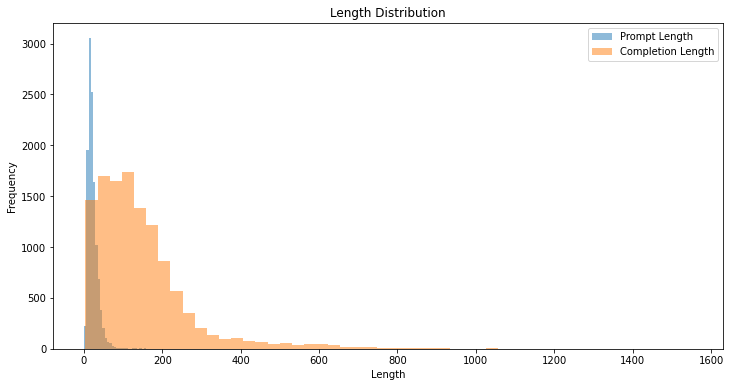

In [9]:
plt.figure(figsize=(12, 6))
plt.hist(sft_data['prompt_length'], bins=50, alpha=0.5, label='Prompt Length')
plt.hist(sft_data['completion_length'], bins=50, alpha=0.5, label='Completion Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Length Distribution')
plt.show()

- 'completion' 열에서 문장 끝이 온점('.')으로 끝나는 비율 계산

In [10]:
end_with_period = sft_data['completion'].apply(lambda x: x.endswith('.')).mean()
print(f"Percentage of completions that end with a period: {end_with_period * 100:.2f}%")

Percentage of completions that end with a period: 88.62%


**rm_data**

- 데이터 정보

In [11]:
rm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10220 entries, 0 to 10219
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   prompt        10220 non-null  object
 1   completion_0  10220 non-null  object
 2   completion_1  10220 non-null  object
 3   completion_2  10220 non-null  object
 4   ranking       10220 non-null  object
dtypes: object(5)
memory usage: 399.3+ KB


In [12]:
rm_data.head()

,prompt,completion_0,completion_1,completion_2,ranking
0,"번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독...",Allow me to answer your question. I know that ...,번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다.,라이언에게 말했다.,"[2, 1, 0]"
1,개포주공아파트는 몇 단지로 이루어져 있나?,개포주공아파트는 다섯 단지로 이루어져 있습니다.,이날 목송에서 구글상위노,개포주공아파트는 총 27개 단지로 이루어져 있습니다.,"[2, 0, 1]"
2,김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?,The diameter of the Metallic domain is bigger ...,"이 질문은 조금 불분명합니다. 김영삼 대통령이 후보 시절에 어떤 발언을 했고, 누가...",김영삼의 후보 시절에 지역표심을 겨냥한 발언은 대통령 당선 전까지 대한민국 정부가 ...,"[1, 2, 0]"
3,페르시아로부터 기원된 아랍요리의 특징이 뭐야,"1. 다양한 스파이스와 허브 사용\n2. 쌀, 콩, 나물, 고기, 양파 등 다양한 ...","- 아랍요리는 소금, 산 재료, 일부 채소, 고기, 생선 또는 난류의 조합으로 만들...",위한 태야 대표 기원들 개인이라 겪고 태야\n\n\n귀식 걸 공개한 구문\n\n사띩...,"[0, 1, 2]"
4,중화인민공화국의 기본 법률은 누가 제정 및 개정하는가?,중화인민공화국의 기본 법률은 중국인민대표대회(국회)가 제정하고 개정합니다.,The limit of the Office of the Vice President is?,중화인민공화국의 기본 법률은 중화인민공화국의 의회가 제정 및 개정합니다.,"[0, 2, 1]"


- 가장 많이 등장하는 단어 탐색

In [13]:
word_counts = Counter(" ".join(rm_data['prompt']).split()).most_common(10)
print(word_counts)

[('몇', 441), ('어떤', 311), ('뭐야', 301), ('수', 282), ('어느', 248), ('언제', 227), ('있나요?', 205), ('한', 204), ('있는', 201), ('좀', 179)]


- 'prompt' 열에서 가장 많이 등장하는 단어 탐색

In [14]:
rm_data['prompt_length'] = rm_data['prompt'].apply(len)

In [15]:
rm_data['prompt_length'].describe()

count    10220.000000
mean        22.203229
std         14.297097
min          0.000000
25%         13.000000
50%         19.000000
75%         28.000000
max        295.000000
Name: prompt_length, dtype: float64

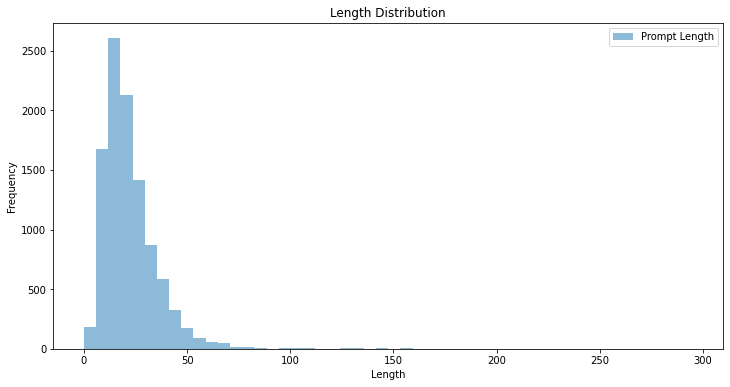

In [16]:
plt.figure(figsize=(12, 6))
plt.hist(rm_data['prompt_length'], bins=50, alpha=0.5, label='Prompt Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Length Distribution')
plt.show()

**ppo_data**

- 데이터 정보

In [17]:
ppo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   prompt  12000 non-null  object
dtypes: object(1)
memory usage: 93.9+ KB


In [18]:
ppo_data.head()

,prompt
0,"번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독..."
1,개포주공아파트는 몇 단지로 이루어져 있나?
2,김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?
3,페르시아로부터 기원된 아랍요리의 특징이 뭐야
4,중화인민공화국의 기본 법률은 누가 제정 및 개정하는가?


- 가장 많이 등장하는 단어 탐색

In [19]:
word_counts = Counter(" ".join(ppo_data['prompt']).split()).most_common(10)
print(word_counts)

[('몇', 506), ('뭐야', 360), ('어떤', 360), ('수', 339), ('어느', 282), ('언제', 268), ('있는', 240), ('있나요?', 240), ('한', 240), ('무엇인가?', 212)]


- 'prompt' 열에서 가장 많이 등장하는 단어 탐색

In [20]:
ppo_data['prompt_length'] = ppo_data['prompt'].apply(len)

In [21]:
ppo_data['prompt_length'].describe()

count    12000.000000
mean        22.180583
std         14.110028
min          0.000000
25%         13.000000
50%         19.000000
75%         28.000000
max        295.000000
Name: prompt_length, dtype: float64

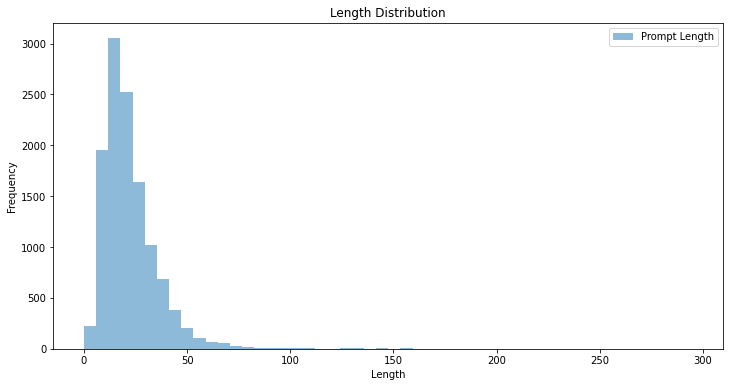

In [22]:
plt.figure(figsize=(12, 6))
plt.hist(ppo_data['prompt_length'], bins=50, alpha=0.5, label='Prompt Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Length Distribution')
plt.show()

#### 데이터 전처리

In [23]:
import re

def clean_text(text):
    # HTML 태그 제거
    text = re.sub(r'<[^>]+>', '', text)
    # 이메일 주소 제거
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
    # URL 제거
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    # 특수 문자 및 숫자 제거 (옵션)
    text = re.sub(r'[^가-힣\s]', '', text)
    return text.strip()  # 양쪽 공백 제거

- 데이터에 텍스트 정제 함수 적용

In [24]:
sft_data['prompt'] = sft_data['prompt'].apply(clean_text)
sft_data['completion'] = sft_data['completion'].apply(clean_text)

In [25]:
rm_data['prompt'] = rm_data['prompt'].apply(clean_text)
rm_data['completion_0'] = rm_data['completion_0'].apply(clean_text)
rm_data['completion_1'] = rm_data['completion_1'].apply(clean_text)
rm_data['completion_2'] = rm_data['completion_2'].apply(clean_text)

In [26]:
ppo_data['prompt'] = ppo_data['prompt'].apply(clean_text)

#### 데이터 json로 변경

In [27]:
sft_data.to_json('./data_kochatgpt/data_cleaning_sft.jsonl', orient='records', lines=True, force_ascii=False)
rm_data.to_json('./data_kochatgpt/data_cleaning_rm.jsonl', orient='records', lines=True, force_ascii=False)
ppo_data.to_json('./data_kochatgpt/data_cleaning_ppo.jsonl', orient='records', lines=True, force_ascii=False)

In [28]:
def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = [json.loads(line) for line in file]
    return data

## SFT(Supervised Fine Tuning)

In [29]:
data_sft = load_jsonl('./data_kochatgpt/data_cleaning_sft.jsonl')
data_sft

[{'prompt': '불고기용 고기 한우에요',
  'completion': '저는 인공지능 챗봇이며 직접적으로 식품에 관한 정보를 가지고 있지 않습니다 하지만 일반적으로 불고기용 고기는 한우 쇠고기 돼지고기 등 다양한 종류의 고기를 사용합니다 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에 한우를 사용하는 경우도 많습니다 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다',
  'tokens': 193,
  'prompt_length': 13,
  'completion_length': 203},
 {'prompt': '쓰던 앱이 유료로 전환됐어',
  'completion': '어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다 하지만 일반적으로 유료 전환된 앱은 기존 무료 앱에서 추가적인 기능이나 서비스를 제공하는 경우가 많습니다 이 경우 유료 전환 이전 가격이 매우 저렴하거나 무료인 경우가 많으므로 앱을 계속 사용하려면 추가적인 비용을 지불해야 할 수 있습니다 하지만 유료 전환 이후에는 기존 사용자 또는 새로운 사용자 모두가 추가 기능과 높은 품질의 서비스를 이용할 수 있게 됩니다 따라서 앱 개발자는 유료 모델로 전환함으로써 앱의 수익을 증가시키고 더 나은 서비스를 제공할 수 있습니다',
  'tokens': 288,
  'prompt_length': 14,
  'completion_length': 305},
 {'prompt': '여친이랑 다툼',
  'completion': '저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다 하지만 다투게 되면 상대방의 말을 경청하는 태도와 서로의 감정을 존중하는 것이 중요합니다 논리적이고 차분한 대화를 통해 문제를 해결해보세요 그리고 서로를 이해하고 서로의 의견을 수용하는 것이 중요합니다',
  'tokens': 153,
  'prompt_length': 7,
  'completion_length': 160},
 {'prompt'

In [30]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments, AutoModelWithLMHead
from copy import deepcopy
from torch.optim import Adam
from transformers import AutoTokenizer, BloomTokenizerFast
from transformers.models.gpt2.tokenization_gpt2 import GPT2Tokenizer
import pandas as pd
import argparse
import copy
import logging
import json
from dataclasses import dataclass, field
from transformers import GPT2LMHeadModel, PreTrainedTokenizerFast
from typing import Optional, Dict, Sequence

### define argment

In [31]:
parser = argparse.ArgumentParser()
parser.add_argument('--data_path_1_SFT', type=str, default='./data_kochatgpt/data_cleaning_sft.jsonl')
parser.add_argument('--model_name', type=str, default='gpt2', choices=['gpt2', 'bloom', 'opt'])
parser.add_argument('--max_epochs', type=int, default=2)
parser.add_argument('--train_batch_size', type=int, default=8)
parser.add_argument('--output_dir', type=str, default='./output_cleaning_sft')

args = parser.parse_args(args=[])

# for test
args.model_name = 'skt/kogpt2-base-v2'  # SK GPT2, https://github.com/SKT-AI/KoGPT2
# args.model_name = 'ajoublue-gpt2-base'  # 아주대, https://github.com/HeegyuKim/language-model

args.max_epochs = 2

print(args)

Namespace(data_path_1_SFT='./data_kochatgpt/data_cleaning_sft.jsonl', model_name='skt/kogpt2-base-v2', max_epochs=2, train_batch_size=8, output_dir='./output_cleaning_sft')


### test & load skt gpt2 kroean

In [32]:
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
                                                    bos_token='</s>', eos_token='</s>', unk_token='<unk>',
                                                    pad_token='<pad>', mask_token='<mask>')
print(tokenizer.tokenize("안녕하세요. 한국어 GPT-2 입니다.😤:)l^o"))

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


['▁안녕', '하', '세', '요.', '▁한국어', '▁G', 'P', 'T', '-2', '▁입', '니다.', '😤', ':)', 'l^o']


In [33]:
model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
text = '근육이 커지기 위해서는'
input_ids = tokenizer.encode(text, return_tensors='pt')
gen_ids = model.generate(input_ids,
                         max_length=128,
                         repetition_penalty=2.0,
                         pad_token_id=tokenizer.pad_token_id,
                         eos_token_id=tokenizer.eos_token_id,
                         bos_token_id=tokenizer.bos_token_id,
                         use_cache=True)
generated = tokenizer.decode(gen_ids[0])
print(generated)

근육이 커지기 위해서는 무엇보다 규칙적인 생활습관이 중요하다.
특히, 아침식사는 단백질과 비타민이 풍부한 과일과 채소를 많이 섭취하는 것이 좋다.
또한 하루 30분 이상 충분한 수면을 취하는 것도 도움이 된다.
아침 식사를 거르지 않고 규칙적으로 운동을 하면 혈액순환에 도움을 줄 뿐만 아니라 신진대사를 촉진해 체내 노폐물을 배출하고 혈압을 낮춰준다.
운동은 하루에 10분 정도만 하는 게 좋으며 운동 후에는 반드시 스트레칭을 통해 근육량을 늘리고 유연성을 높여야 한다.
운동 후 바로 잠자리에 드는 것은 피해야 하며 특히 아침에 일어나면 몸이 피곤해지기 때문에 무리하게 움직이면 오히려 역효과가 날 수도 있다.
운동을


In [34]:
generator = pipeline("text-generation", model=model, tokenizer=tokenizer)
generation_args = dict(
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)
generator(
    ["0 : **는 게임 좋아하니\n1 :",
    "0 : 어제 강남에서 살인사건 났대 ㅜㅜ 너무 무서워\n1 : 헐 왜? 무슨 일 있었어?\n0 : 사진보니까 막 피흘리는 사람있고 경찰들이 떠서 제압하고 난리도 아니었다던데??\n1 :",
    "0 : 자기야 어제는 나한테 왜 그랬어?\n1 : 뭔 일 있었어?\n0 : 어떻게 나한테 말도 없이 그럴 수 있어? 나 진짜 실망했어\n1 : "],
    **generation_args
)

/opt/conda/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


[[{'generated_text': '0 : **는 게임 좋아하니\n1 : ***는 게임 싫어하니까\n'}],
 [{'generated_text': '0 : 어제 강남에서 살인사건 났대 ㅜㅜ 너무 무서워\n1 : 헐 왜? 무슨 일 있었어?\n0 : 사진보니까 막 피흘리는 사람있고 경찰들이 떠서 제압하고 난리도 아니었다던데??\n1 : 저희 부모님도 이 사건 때문에 스트레스를 많이 받으셨을텐데...\n2 : 피해자분께 죄송하다는 말씀 드리고 싶네요...\n3 : 정말 죄송합니다.\n이런 일이 있을 줄은 꿈에도 몰랐는데...\n4 : 제발 부탁드립니다.\n5 :'}],
 [{'generated_text': '0 : 자기야 어제는 나한테 왜 그랬어?\n1 : 뭔 일 있었어?\n0 : 어떻게 나한테 말도 없이 그럴 수 있어? 나 진짜 실망했어\n1 : 뭘 하고 싶었어?\n2 : 아냐. 내가 할 수 있는 게 아무것도 없어.\n3 : 뭐라고 했지?\n3 : 너랑 같이 놀아줄래?\n4 : 우린 아무 상관 없어.\n5 : 네가 무슨 말을 하든 상관 없어.\n6 : 그게 무슨 말이지?\n7'}]]

### data config

In [35]:
IGNORE_INDEX = -100
DEFAULT_PAD_TOKEN = "[PAD]"
DEFAULT_EOS_TOKEN = "</s>"
DEFAULT_BOS_TOKEN = "</s>"
DEFAULT_UNK_TOKEN = "</s>"
PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context.\n"
        "아래는 작업을 설명하는 명령어와 추가적 맥락을 제공하는 입력이 짝을 이루는 예제입니다.\n\n"
        "Write a response that appropriately completes the request.\n요청을 적절히 완료하는 응답을 작성하세요.\n\n"
        "### Instruction(명령어):\n{prompt}\n\n### Input(입력):\n{input}\n\n### Response(응답):"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task.\n"
        "아래는 작업을 설명하는 명령어입니다.\n\n"
        "Write a response that appropriately completes the request.\n명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.\n\n"
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    ),
}

### Model preparation

In [36]:
model = AutoModelForCausalLM.from_pretrained(args.model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(
    args.model_name,
    padding_side="right",
    model_max_length=512,
)
tokenizer.add_special_tokens(
    {
        "eos_token": DEFAULT_EOS_TOKEN,
        "bos_token": DEFAULT_BOS_TOKEN,
        "unk_token": DEFAULT_UNK_TOKEN,
    }
)
tokenizer.pad_token = tokenizer.eos_token
print(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


### prepare data

In [37]:
class SFT_dataset(Dataset):
    '''SFT dataset by wygo'''
    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        ## format
        pattern_instruction = 'prompt'  # instruction
        pattern_input = 'input'         # 내 데이터엔 input이 없다
        pattern_output = 'completion'   # output

        # data_path_1_SFT = './data_kochatgpt/data_cleaning_sft.jsonl'
        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = load_jsonl(data_path_1_SFT) 
            if verbose:
                print('## data check ##')
                print((list_data_dict[0]))
 
        ## 데이터셋 만들기, source와 target
        prompt_input, prompt_no_input = PROMPT_DICT["prompt_input"], PROMPT_DICT["prompt_no_input"]  # 템플릿 가져오기

        # 입력
        sources = []
        for example in list_data_dict:
            if example.get(pattern_input, "") != "":
                tmp = prompt_input.format_map(example)
            else:
                tmp = prompt_no_input.format_map(example)
            sources.append(tmp)

        # 출력
        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")

        if verbose:
            idx = 0
            print((sources[idx]))
            print((targets[idx]))
            print("Tokenizing inputs... This may take some time...")

        # data_dict = preprocess(sources, targets, tokenizer)  # https://github.com/Beomi/KoAlpaca/blob/04704348d58b8b1c2e2638d6437a04b4e8ba1823/train.py#L124
        examples = [s + t for s, t in zip(sources, targets)]

        # source data tokenized
        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source만
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target


        ## 입력은 source, 출력은 source+target 이지만 학습은 target 부분만
        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = IGNORE_INDEX  # source 부분은 -100으로 채운다

        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))

    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        """Tokenize a list of strings."""
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

In [38]:
@dataclass
class DataCollatorForSupervisedDataset(object):
    """Collate examples for supervised fine-tuning."""

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=IGNORE_INDEX)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

In [39]:
train_dataset = SFT_dataset(data_path_1_SFT=args.data_path_1_SFT, tokenizer=tokenizer)
eval_dataset  = None  # eval은 안함
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

# check
print('input : %s'%train_dataset.input_ids[0])
print('output: %s'%train_dataset.labels[0])

input : tensor([ 9707, 10630, 15115,   739,  9969, 29145, 13799, 13394, 37091, 10651,
        44389, 10272, 22712,   441, 41261,  9792, 13612, 10448, 10712,   449,
         9585, 22093,  7162, 15454, 21029, 14266,  8006, 10542,   375,   429,
          456, 25974, 13612, 22178,  9792,   454,  9549, 20549, 44389, 10272,
        13612, 30258, 33191, 11485, 10272, 10630,   463, 11925, 21212, 38054,
         9792, 11370, 25299, 14104, 16043,  9585, 25841, 18904, 10495, 29095,
        21307, 17754,  9033, 30757,  8137,  9727,  8702, 41547,   375,   378,
          378,   378, 14659, 13394, 37091, 10651,   383, 25841,  8006, 14914,
          375,  7673, 20479,  8091, 22311,  9036, 30902, 12002,   375,   378,
          378,   378, 41951,   454,  9549, 20549,   383,  8142,  7192, 14914,
        37767, 13753,  8263,  7166,   739,  8352,  7659,  9639, 25585, 13600,
         8022,  9378, 11532,  9887, 11218,  9111, 16913,  7182, 10351, 10561,
         9128, 20479,  8091,  9065,  9446, 33869, 46311,

### training

In [40]:
training_args = TrainingArguments(
    output_dir="./test",           # The output directory
    overwrite_output_dir=True,     # overwrite the content of the output directory
    num_train_epochs=3,            # number of training epochs
    per_device_train_batch_size=4, # batch size for training
    per_device_eval_batch_size=4,  # batch size for evaluation
    eval_steps=3,                  # Number of update steps between two evaluations.
    save_steps=500,                # after # steps model is saved
    warmup_steps=5,                # number of warmup steps for learning rate scheduler
    prediction_loss_only=True,
    )

In [41]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

In [42]:
def safe_save_model_for_hf_trainer(trainer: transformers.Trainer, output_dir: str):
    """Collects the state dict and dump to disk."""
    state_dict = trainer.model.state_dict()
    if trainer.args.should_save:
        cpu_state_dict = {key: value.cpu() for key, value in list(state_dict.items())}
        del state_dict
        trainer._save(output_dir, state_dict=cpu_state_dict)  # noqa

In [43]:
trainer.train()
trainer.save_state()
safe_save_model_for_hf_trainer(trainer=trainer, output_dir=args.output_dir)

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,3.133000
1000,2.942800
1500,2.906400
2000,2.850000
2500,2.840800
3000,2.782200
3500,2.204200
4000,2.234300
4500,2.215200
5000,2.198000


### Inference Test

In [44]:
generator = pipeline('text-generation', model=args.output_dir, tokenizer=tokenizer)
# generator = pipeline('text-generation', model=model.cpu(), tokenizer=tokenizer, config={'max_length':800})

generation_args = dict(
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어',
               '오늘 미세먼지 어때?']
list_prompt = [PROMPT_DICT['prompt_no_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

list_result = generator(list_prompt, **generation_args)
for prompt, result in zip(list_prompt, list_result):
    print(('#'*70))
    print(('completion: %s'%(result[0]['generated_text'])))

/opt/conda/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


######################################################################
completion: Below is an instruction that describes a task.
아래는 작업을 설명하는 명령어입니다.

Write a response that appropriately completes the request.
명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.

### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):저는 인공지능 언어모델로써 답변을 드리고 있습니다 불고기용 고기는 한국식 된장과 일본식 된장을 섞어 만든 음식입니다 일반적으로 한국에서 사용되는 고기는 한우 쇠고기 돼지고기 등이 사용될 수 있습니다 하지만 개인의 건강 상태와 식습관 등에 따라 다양한 선택이 가능합니다
######################################################################
completion: Below is an instruction that describes a task.
아래는 작업을 설명하는 명령어입니다.

Write a response that appropriately completes the request.
명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):리처드 닉슨은 년 대선 캠프에서 부통령직을 수행했습니다 언급하신 대로 리처드 닉슨은 년 대통령 선거에서 부통령 후보로 출마하였습니다 예시로는 리처드 닉슨은 대선 캠프 기간 동안 부통령 후보로 출마하지 않았습니다 출처 언급된 것처럼 리처드 닉슨은 당시 대선 캠
######################################################################
completion: Below is an i

## RM(Reward Modeling)

In [67]:
# # for ColossalAI
# !pip install colossalai==0.2.7

# # setup data
# !git clone https://github.com/airobotlab/KoChatGPT
# !mv KoChatGPT/data_kochatgpt .
# !mv KoChatGPT/img .

# %cd KoChatGPT/colossalai_ChatGPT_230319/
# !pip install .
# %cd ../../

fatal: destination path 'KoChatGPT' already exists and is not an empty directory.
mv: cannot move 'KoChatGPT/data_kochatgpt' to './data_kochatgpt': Directory not empty
mv: cannot move 'KoChatGPT/img' to './img': Directory not empty
/aiffel/aiffel/KoChatGPT/KoChatGPT/colossalai_ChatGPT_230319
Processing /aiffel/aiffel/KoChatGPT/KoChatGPT/colossalai_ChatGPT_230319
  Preparing metadata (setup.py) ... done
  Created wheel for chatgpt: filename=chatgpt-0.1.0-py3-none-any.whl size=46664 sha256=fbc6a72a26511bf2d3f7ea925b0aaf510b1666a64d958f2ca3c05ddaade08515
  Stored in directory: /tmp/pip-ephem-wheel-cache-2zeikj_d/wheels/30/90/68/e1757d96a1e585e48873e9b2fef157733183d39f2b2fdbddf2
Successfully built chatgpt
  Attempting uninstall: chatgpt
    Found existing installation: chatgpt 2.2212.0
    Uninstalling chatgpt-2.2212.0:
      Successfully uninstalled chatgpt-2.2212.0
/aiffel/aiffel/KoChatGPT


In [75]:
data_rm = load_jsonl('./data_kochatgpt/data_cleaning_rm.jsonl')
data_rm

[{'prompt': '번디는 자신이 탐정잡지 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나',
  'completion_0': '',
  'completion_1': '번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다',
  'completion_2': '라이언에게 말했다',
  'ranking': [2, 1, 0],
  'prompt_length': 59},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나',
  'completion_0': '개포주공아파트는 다섯 단지로 이루어져 있습니다',
  'completion_1': '이날 목송에서 구글상위노',
  'completion_2': '개포주공아파트는 총 개 단지로 이루어져 있습니다',
  'ranking': [2, 0, 1],
  'prompt_length': 23},
 {'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는',
  'completion_0': '',
  'completion_1': '이 질문은 조금 불분명합니다 김영삼 대통령이 후보 시절에 어떤 발언을 했고 누가 그 발언을 문제삼았는지에 따라 답이 다를 수 있습니다만약 김영삼 대통령이 후보 시절에 지역표심을 겨냥한 발언을 했다는 가정하에 그 발언을 문제삼은 후보가 누구였는지를 대답하자면 그 답은 이화선 당시 민주당 대통령 후보가 될 것입니다 년 총선 때 김영삼 대선후보는 집값이 오른 노량진역 부근의 부동산 가격은 세월호 폭침 후 강남 도시재생 일환으로 상승했다는 발언을 했습니다 하지만 이화선 후보는 이 발언을 전국적으로 경제적 발전이 이루어지지 않은 지방민의 마음을 멀리해지려는 무례한 발언이라고 비판하며 문제삼았습니다하지만 이 질문을 답변하는 데 있어서 보다 명확한 정보가 있으면 답변을 보완할 수 있습니다',
  'completion_2': '김영삼의 후보 시절에 지역표심을 겨냥한 발언은 대통령 당선 전까지 대한민국 정부가 추구하고 있는 민주주의 

In [68]:
import argparse
import loralib as lora
torch.cuda.empty_cache()
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.models.bloom import BLOOMRM
from chatgpt.models.gpt import GPTRM
from chatgpt.models.opt import OPTRM
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import ColossalAIStrategy, DDPStrategy, NaiveStrategy
from chatgpt.models.base import RewardModel
from datasets import load_dataset
from torch.optim import Adam
from transformers import AutoTokenizer, BloomTokenizerFast
from transformers.models.gpt2.tokenization_gpt2 import GPT2Tokenizer
from colossalai.nn.optimizer import HybridAdam
from typing import Optional
import torch.nn as nn
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model

### data config

In [69]:
IGNORE_INDEX = -100
DEFAULT_PAD_TOKEN = "[PAD]"
DEFAULT_EOS_TOKEN = "</s>"
DEFAULT_BOS_TOKEN = "</s>"
DEFAULT_UNK_TOKEN = "</s>"
PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context.\n"
        "아래는 작업을 설명하는 명령어와 추가적 맥락을 제공하는 입력이 짝을 이루는 예제입니다.\n\n"
        "Write a response that appropriately completes the request.\n요청을 적절히 완료하는 응답을 작성하세요.\n\n"
        "### Instruction(명령어):\n{prompt}\n\n### Input(입력):\n{input}\n\n### Response(응답):"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task.\n"
        "아래는 작업을 설명하는 명령어입니다.\n\n"
        "Write a response that appropriately completes the request.\n명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.\n\n"
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    ),
}

### define argment

In [70]:
parser = argparse.ArgumentParser()
parser.add_argument('--output_dir', type=str, default='./output_cleaning_rm')
parser.add_argument('--data_path_2_RM', type=str, default='./data_kochatgpt/data_cleaning_rm.jsonl', help='https://huggingface.co/datasets/fka/awesome-chatgpt-prompts/blob/main/prompts.csv')
parser.add_argument('--strategy',
                    choices=['naive', 'ddp', 'colossalai_gemini', 'colossalai_zero2'],
                    default='naive')
parser.add_argument('--model', type=str, default='gpt2', choices=['gpt2', 'bloom', 'opt'])
parser.add_argument('--pretrain', type=str, default=None)
parser.add_argument('--dataset', type=str, default='Dahoas/rm-static')
parser.add_argument('--save_path', type=str, default='rm_ckpt.pth')
parser.add_argument('--max_epochs', type=int, default=10)
parser.add_argument('--batch_size', type=int, default=4)
parser.add_argument('--lora_rank', type=int, default=0, help="low-rank adaptation matrices rank")
parser.add_argument('--max_len', type=int, default=512)  # wygo 추가

args = parser.parse_args(args=[])

# for test
args.max_epochs = 3
args.pretrain = 'skt/kogpt2-base-v2'  # pretrained 모델 가져오기
args.verbose = True

print(args)
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

Namespace(output_dir='./output_cleaning_rm', data_path_2_RM='./data_kochatgpt/data_cleaning_rm.jsonl', strategy='naive', model='gpt2', pretrain='skt/kogpt2-base-v2', dataset='Dahoas/rm-static', save_path='rm_ckpt.pth', max_epochs=3, batch_size=4, lora_rank=0, max_len=512, verbose=True)


### configure strategy

In [71]:
if args.strategy == 'naive':
    strategy = NaiveStrategy()
elif args.strategy == 'ddp':
    strategy = DDPStrategy()
elif args.strategy == 'colossalai_gemini':
    strategy = ColossalAIStrategy(stage=3, placement_policy='cuda')
elif args.strategy == 'colossalai_zero2':
    strategy = ColossalAIStrategy(stage=2, placement_policy='cuda')
else:
    raise ValueError(f'Unsupported strategy "{args.strategy}"')

In [72]:
class GPTRM_custom(RewardModel):
    """
    GPT Reward model.
    Args:
        pretrained (str): Pretrained model name or path.
        config (GPT2Config): Model config.
        checkpoint (bool): Enable gradient checkpointing.
        lora_rank (int): Rank of the low-rank approximation.
        lora_train_bias (str): LoRA bias training mode.
    """

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))  # wygo 추가!!!
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()


        # model = model.resize_token_embeddings(len(tokenizer))

        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        # 추가, 230421
        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained

    # 추가, 230421, config.json을 생성하기 위해 추가
    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

### configure model, tokenizer

In [73]:
with strategy.model_init_context():
    # load pretrained gpt2
    if args.model == 'gpt2':
        # tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        # tokenizer = AutoTokenizer.from_pretrained(args.pretrain)
        tokenizer = AutoTokenizer.from_pretrained(args.pretrain, padding_side="right", model_max_length=512)
        tokenizer.add_special_tokens(
            {
                "eos_token": DEFAULT_EOS_TOKEN,
                "bos_token": DEFAULT_BOS_TOKEN,
                "unk_token": DEFAULT_UNK_TOKEN,
            }
        )
        tokenizer.pad_token = tokenizer.eos_token
        model = GPTRM_custom(pretrained=args.pretrain, lora_rank=args.lora_rank, tokenizer=tokenizer).cuda()

    elif args.model == 'bloom':
        model = BLOOMRM(pretrained=args.pretrain, lora_rank=args.lora_rank).cuda()
        tokenizer = BloomTokenizerFast.from_pretrained(args.pretrain)

    elif args.model == 'opt':
        model = OPTRM(pretrained=args.pretrain, lora_rank=args.lora_rank).cuda()
        tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")

    else:
        raise ValueError(f'Unsupported model "{args.model}"')


    # model.resize_token_embeddings(len(tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### make ranking data to chosen, rejetced data

In [76]:
# with open(args.data_path_2_RM, "r", encoding='utf-8-sig') as json_file:
#     list_data_dict = json.load(json_file)
#     if args.verbose:
#         print('## data check ##')
#         print((list_data_dict[0]))
with open(args.data_path_2_RM, "r", encoding='utf-8-sig') as file:
    list_data_dict = [json.loads(line) for line in file]
    if args.verbose:
        print('## data check ##')
        print((list_data_dict[0]))

total_data_ranking2chosen = []
for tmp in list_data_dict:
    one_data_ranking2chosen = []

    # data 1) 0 VS 1
    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)


    # data 2) 0 VS 2
    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    # data 1) 1 VS 2
    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)



    total_data_ranking2chosen.extend(one_data_ranking2chosen)

print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])

## data check ##
{'prompt': '번디는 자신이 탐정잡지 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나', 'completion_0': '', 'completion_1': '번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다', 'completion_2': '라이언에게 말했다', 'ranking': [2, 1, 0], 'prompt_length': 59}
before data num: 10220
after  data num: 30660
data example: 
{'prompt': '애플은 리사를 어떻게 처리했어', 'chosen': '애플이 누구인지 명확히 알 수 없어서 리사가 누구인지와 어떤 상황에서 처리되었는지에 대한 추가적인 정보가 필요합니다 따라서 보다 정확한 답변을 제공할 수 없습니다', 'rejected': '애플은 리사를 위해 고객 서비스 부서에서 고객 다양한 컴퓨터 관련 문제에 대해 응답하는 데 필요한 모든 지원을 제공했습니다 사용자가 하드웨어 문제를 경험할 때 전문가들은 필요한 수리수리 추가 부품 제공 소프트웨어 업그레이드 등을 제공해 드릴 수 있습니다 또한 사용자가 사용 방법 문제나 기타 문제를 경험할 때 대화 상대로 사용자를 지원할 수 있는 전문 고객 서비스 직원들이 사용자에게 상담하고 도움을 주는 데 도움이 될 수 있는 정보를 제공합니다 또한 인터넷에서 제공되는 정보를 통해 문제를 해결하거나 고객 서비스 웹 사이트를 통해 자신의 문제를 진단할 수 있도록 하는 등 다양한 방법으로 리사를 처리해 왔습니다'}


### prepare for data and dataset

In [77]:
import random
random.seed(230319)
# list_tmp = list(range(10))
random.shuffle(total_data_ranking2chosen)
print(total_data_ranking2chosen[45])

# train_data = total_data_ranking2chosen[:-1000]  # 29000 학습
# eval_data = total_data_ranking2chosen[-1000:0]  # 1000개만 평가

train_data = total_data_ranking2chosen[:100]  # 29000 학습
eval_data = total_data_ranking2chosen[100:130]  # 1000개만 평가


train_dataset = RewardDataset(train_data, tokenizer, args.max_len)
eval_dataset = RewardDataset(eval_data, tokenizer, args.max_len)

# check
idx = 10
print('#'*70)
print('## prompt ##')
print(train_data[idx]['prompt'])
print('#'*70)
print('## chosen ##')
print(train_data[idx]['chosen'])
print('#'*70)
print('## rejected ##')
print(train_data[idx]['rejected'])

{'prompt': '유아인이 류승완 감독을 만나 영화 베테랑의 시나리오를 받았던 곳은', 'chosen': '유아인이 류승완 감독을 만나 영화 베테랑의 시나리오를 받았던 곳은 류승완의 사무실입니다', 'rejected': '대구 영화사옥'}


100%|██████████| 30/30 [00:00<00:00, 1496.15it/s]

######################################################################
## prompt ##
체크인 되나요
######################################################################
## chosen ##
제가  챗봇이기 때문에 호텔이나 항공편 등으로 어떤 체크인을 말씀하시는 것인지 구체적으로 설명해주시면 답변을 드리겠습니다
######################################################################
## rejected ##
다시 한번 가지게임이지 않아 가지게임이지


### configure optimizer

In [78]:
if args.strategy.startswith('colossalai'):
    optim = HybridAdam(model.parameters(), lr=5e-5)
else:
    optim = Adam(model.parameters(), lr=5e-5)

In [79]:
# batch_size here is expected to be C(k,2), k means # response of each prompt
# be limited with the format of dataset 'Dahoas/rm-static', we'd better use batch_size as 1
trainer = RewardModelTrainer(model=model,
                             strategy=strategy,
                             optim=optim,
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=args.batch_size,
                             max_epochs=args.max_epochs)

### train

In [80]:
trainer.fit(use_lora=args.lora_rank)

Train step of epoch 0: 100%|██████████| 25/25 [00:26<00:00,  1.06s/it, loss=0.613, dist_mean=0.233]

Train step of epoch 1: 100%|██████████| 25/25 [00:25<00:00,  1.00s/it, loss=1, dist_mean=0.839]

Train epoch: 100%|██████████| 3/3 [01:16<00:00, 25.46s/it]


### save

In [81]:
# save model checkpoint after fitting on only rank0
strategy.save_model(model, os.path.join(args.output_dir, 'RM.pt'), only_rank0=True)
# save optimizer checkpoint on all ranks
strategy.save_optimizer(optim,
                        os.path.join(args.output_dir, 'RM_optim_checkpoint_%d.pt' % (torch.cuda.current_device())),
                        only_rank0=False)

model.save_pretrained(args.output_dir)  # config.json 생성

In [82]:
# 보상모델 체크
def inference_RM(input_text='인공지능은 인공지능 입니다'):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward


# input_text = '한국은 대한민국 입니다'
input_text = '인공지능은 인공지능 입니다'

output_reward = inference_RM(input_text=input_text)

input: 인공지능은 인공지능 입니다
reward score: -3.1


## PPO(Proximal Policy Optimization)

In [104]:
data_ppo = load_jsonl('./data_kochatgpt/data_cleaning_ppo.jsonl')
data_ppo

[{'prompt': '번디는 자신이 탐정잡지 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나',
  'prompt_length': 59},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나', 'prompt_length': 23},
 {'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는', 'prompt_length': 34},
 {'prompt': '페르시아로부터 기원된 아랍요리의 특징이 뭐야', 'prompt_length': 24},
 {'prompt': '중화인민공화국의 기본 법률은 누가 제정 및 개정하는가', 'prompt_length': 30},
 {'prompt': '송편은 요 얼마예요', 'prompt_length': 11},
 {'prompt': '이름로 예약했는데 확인 부탁드려도 될까요', 'prompt_length': 26},
 {'prompt': '지루가 데뷔골을 넣은 경기는 어느팀과의 경기였나', 'prompt_length': 27},
 {'prompt': '비탈리 쿠투조프가  밀란 첫 시즌에 몇 경기 출전했어', 'prompt_length': 31},
 {'prompt': '부자 되게 해주세요', 'prompt_length': 10},
 {'prompt': '여의도 시범아파트는 몇 개의 동으로 구성되었나', 'prompt_length': 26},
 {'prompt': '행정규칙과 다른 룰을 이용하여 사건의 결론을 도출할 수 있는 기관은', 'prompt_length': 38},
 {'prompt': '폐순비는 누구의 후궁이 되었지', 'prompt_length': 16},
 {'prompt': '월 일 전당회의로 당선된 당의장의 이름은', 'prompt_length': 25},
 {'prompt': '더 많이 들어가는 상자는 없나요', 'prompt_length': 18},
 {'prompt': '애플은 리사를 어떻게 처리했어', 'prompt_length': 

In [83]:
import argparse
from copy import deepcopy
torch.cuda.empty_cache()
from chatgpt.models.base import RewardModel
from chatgpt.models.bloom import BLOOMActor, BLOOMCritic
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.models.opt import OPTActor, OPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import ColossalAIStrategy, DDPStrategy, NaiveStrategy
from torch.optim import Adam
from transformers import AutoTokenizer, BloomTokenizerFast
from transformers.models.gpt2.tokenization_gpt2 import GPT2Tokenizer
from colossalai.nn.optimizer import HybridAdam

In [84]:
## wy 추가
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## clossalAI error 해결
os.environ['RANK'] = '0'
os.environ['LOCAL_RANK'] = '0'
os.environ['WORLD_SIZE'] = '2'
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '42043'

### data config

In [85]:
IGNORE_INDEX = -100
DEFAULT_PAD_TOKEN = "[PAD]"
DEFAULT_EOS_TOKEN = "</s>"
DEFAULT_BOS_TOKEN = "</s>"
DEFAULT_UNK_TOKEN = "</s>"
PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context.\n"
        "아래는 작업을 설명하는 명령어와 추가적 맥락을 제공하는 입력이 짝을 이루는 예제입니다.\n\n"
        "Write a response that appropriately completes the request.\n요청을 적절히 완료하는 응답을 작성하세요.\n\n"
        "### Instruction(명령어):\n{prompt}\n\n### Input(입력):\n{input}\n\n### Response(응답):"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task.\n"
        "아래는 작업을 설명하는 명령어입니다.\n\n"
        "Write a response that appropriately completes the request.\n명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.\n\n"
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    ),
}

### define argment

In [98]:
parser = argparse.ArgumentParser()
parser.add_argument('--data_path_3_PPO', type=str, default='./data_kochatgpt/data_cleaning_ppo.jsonl')
parser.add_argument('--output_dir', type=str, default='./output_cleaning_ppo')
parser.add_argument('--strategy',
                    choices=['naive', 'ddp', 'colossalai_gemini', 'colossalai_zero2'],
                    default='naive')
parser.add_argument('--model', type=str, default='gpt2', choices=['gpt2', 'bloom', 'opt'])
parser.add_argument('--pretrain', type=str, default=None)
parser.add_argument('--num_episodes', type=int, default=10)
parser.add_argument('--max_timesteps', type=int, default=3)
parser.add_argument('--update_timesteps', type=int, default=3)
parser.add_argument('--max_epochs', type=int, default=5)
parser.add_argument('--train_batch_size', type=int, default=8)
parser.add_argument('--lora_rank', type=int, default=0, help="low-rank adaptation matrices rank")
parser.add_argument('--max_length', type=int, default=250)
args = parser.parse_args(args=[])

# for test
args.output_dir = './output_cleaning_ppo'
args.pretrain = 'skt/kogpt2-base-v2'  # pretrained 모델 가져오기


## 이곳 수정!!
args.pretrain_actor = './output_cleaning_sft'  # SFT 모델 가져오기
args.pretrain_critic = './output_cleaning_rm'  # RM 모델 가져오기
# args.pretrain_actor = args.pretrain
# args.pretrain_critic = args.pretrain

args.num_episodes = 1
args.max_epochs   = 1

print(args)
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

Namespace(data_path_3_PPO='./data_kochatgpt/data_cleaning_ppo.jsonl', output_dir='./output_cleaning_ppo', strategy='naive', model='gpt2', pretrain='skt/kogpt2-base-v2', num_episodes=1, max_timesteps=3, update_timesteps=3, max_epochs=1, train_batch_size=8, lora_rank=0, max_length=250, pretrain_actor='./output_cleaning_sft', pretrain_critic='./output_cleaning_rm')


### configure strategy

In [99]:
if args.strategy == 'naive':
    strategy = NaiveStrategy()
elif args.strategy == 'ddp':
    strategy = DDPStrategy()
elif args.strategy == 'colossalai_gemini':
    strategy = ColossalAIStrategy(stage=3, placement_policy='cuda')
elif args.strategy == 'colossalai_zero2':
    strategy = ColossalAIStrategy(stage=2, placement_policy='cuda')
else:
    raise ValueError(f'Unsupported strategy "{args.strategy}"')

### configure model, tokenizer

In [100]:
with strategy.model_init_context():
    if args.model == 'gpt2':
        actor = GPTActor(pretrained=args.pretrain_actor, lora_rank=args.lora_rank).to(torch.cuda.current_device())
        critic = GPTCritic(pretrained=args.pretrain_critic, lora_rank=args.lora_rank).to(torch.cuda.current_device())
        # tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        # tokenizer.pad_token = tokenizer.eos_token
        tokenizer = AutoTokenizer.from_pretrained(args.pretrain, padding_side="right", model_max_length=512)
        tokenizer.add_special_tokens(
            {
                "eos_token": DEFAULT_EOS_TOKEN,
                "bos_token": DEFAULT_BOS_TOKEN,
                "unk_token": DEFAULT_UNK_TOKEN,
            }
        )
        tokenizer.pad_token = tokenizer.eos_token



    elif args.model == 'bloom':
        actor = BLOOMActor(pretrained=args.pretrain, lora_rank=args.lora_rank).to(torch.cuda.current_device())
        critic = BLOOMCritic(pretrained=args.pretrain, lora_rank=args.lora_rank).to(torch.cuda.current_device())
        tokenizer = BloomTokenizerFast.from_pretrained(args.pretrain)
        tokenizer.pad_token = tokenizer.eos_token
    elif args.model == 'opt':
        actor = OPTActor(pretrained=args.pretrain, lora_rank=args.lora_rank).to(torch.cuda.current_device())
        critic = OPTCritic(pretrained=args.pretrain, lora_rank=args.lora_rank).to(torch.cuda.current_device())
        tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")
    else:
        raise ValueError(f'Unsupported model "{args.model}"')

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### configure optimizer

In [101]:
if args.strategy.startswith('colossalai'):
    actor_optim = HybridAdam(actor.parameters(), lr=5e-6)
    critic_optim = HybridAdam(critic.parameters(), lr=5e-6)
else:
    actor_optim = Adam(actor.parameters(), lr=5e-6)
    critic_optim = Adam(critic.parameters(), lr=5e-6)

### setting the models

In [102]:
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = strategy.prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

### prepare data

In [106]:
# # prepare data
# with open(args.data_path_3_PPO, "r", encoding='utf-8-sig') as json_file:
#     list_data_dict = json.load(json_file)
#     list_prompt = [tmp['prompt'] for tmp in list_data_dict]

with open(args.data_path_3_PPO, "r", encoding='utf-8-sig') as file:
    list_data_dict = [json.loads(line.strip()) for line in file if line.strip()]
    # prompt만 추출
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

print(list_prompt)
print('\n\n\n')
print(tokenize_fn('I want you to act as a linux terminal.'))

['번디는 자신이 탐정잡지 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나', '개포주공아파트는 몇 단지로 이루어져 있나', '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는', '페르시아로부터 기원된 아랍요리의 특징이 뭐야', '중화인민공화국의 기본 법률은 누가 제정 및 개정하는가', '송편은 요 얼마예요', '이름로 예약했는데 확인 부탁드려도 될까요', '지루가 데뷔골을 넣은 경기는 어느팀과의 경기였나', '비탈리 쿠투조프가  밀란 첫 시즌에 몇 경기 출전했어', '부자 되게 해주세요', '여의도 시범아파트는 몇 개의 동으로 구성되었나', '행정규칙과 다른 룰을 이용하여 사건의 결론을 도출할 수 있는 기관은', '폐순비는 누구의 후궁이 되었지', '월 일 전당회의로 당선된 당의장의 이름은', '더 많이 들어가는 상자는 없나요', '애플은 리사를 어떻게 처리했어', '원피스의 원래 주인이 누구였어', '네 선생님 기다려주셔서 감사합니다 차량 차명이 어떻게 되세요', '미스터 허드슨과 팀을 이룬 밴드의 이름은', '그럼 이렇게 해서 얼마죠', '매매하고 전세하고 차이가 좀 있나요', '합기도 배우면 나중에 무슨 일할 수 있어요', '강정호가 메이저리그 월의 신인상을 수상한 해는', '메뉴판 있어요', '계약금은 얼마 정도 해요', '년을 기준으로 용인시에 사는 사람들의 수를 알려줘', '스페인이 속해있는 반도의 이름이 뭐야', '국민대추도회가 언제 생겼어', '개성의 박연폭포 설악산의 대승폭포와 더불어 조선 대 폭포로 뽑히는 구룡폭포는 어디에 위치하고 있는가', '단무지 조금 더 주실래요', '하이므무샤이트에서 유명한 기술이 뭐야', '묵시록에서 천사들은 하느님의 무엇으로 심판과 천지개벽을 주도한다고 하는가', '당김음이라고 하는 용어로 어울리는 한도 내에서 박자를 수정하는 것을 뜻하는 용어는 무엇인가요', '차는 앞에 세워놔도 되죠', '날 사랑하는 이유가 뭘까', '남자친구가 질투하는 거 귀여워', '최은경은 에

### configure trainer

In [107]:
trainer = PPOTrainer(strategy,
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=args.max_epochs,
                     train_batch_size=args.train_batch_size,
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

### train!

In [108]:
trainer.fit(list_prompt,  # 입력 prompt
            num_episodes=args.num_episodes,
            max_timesteps=args.max_timesteps,
            update_timesteps=args.update_timesteps)

Episode [1/1]: 100%|██████████| 3/3 [00:22<00:00,  7.42s/it]


### save

In [109]:
# save model checkpoint after fitting on only rank0
strategy.save_model(actor, os.path.join(args.output_dir, 'actor.pt'), only_rank0=True)
# save optimizer checkpoint on all ranks
strategy.save_optimizer(actor_optim,
                        os.path.join(args.output_dir, 'actor_optim_checkpoint_%d.pt' % (torch.cuda.current_device())),
                        only_rank0=False)

### inference

In [110]:
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=args.max_length,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print('#' * 70)
    print(output)
    return output


list_prompt = [
    '불고기용 고기 한우에요?',
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_no_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text)

######################################################################
Below is an instruction that describes a task.
아래는 작업을 설명하는 명령어입니다.

Write a response that appropriately completes the request.
명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.

### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):저는 인공지능 챗봇이므로 음식을 조리하거나 식당에 대한 정보를 알지 못합니다 하지만 일반적으로 한국에서 제공하는 고육류는 고기나 오갈비 무침 등 다양하게 판매됩니다 하지만 지역과 상점에 따라 다를 수 있으니 해당 지역의 고육점을 참고하시는 것이 좋겠습니다   챗봇이므로 정확한 정보를 얻으실 수 없습니다 챗봇의 이름으로는 고기나 오갈비 무침 김치 무침 생선 고기 등 다양한 것들이 있을 수 있습니다 챗봇은 사용자들의 질문에 답변을 제공해드리는 역할을 하여 신뢰성 높은 고객 서비스 제공에 기여하고 있습니다  챗봇은 사용자들의 질문에 정확하고 상세한 답변을 제공해드리는 역할을 하여 사용
######################################################################
Below is an instruction that describes a task.
아래는 작업을 설명하는 명령어입니다.

Write a response that appropriately completes the request.
명령어에 따른 요청을 적절히 완료하는 응답을 작성하세요.

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):리처드 닉슨이 41대 부통령을 맡았던 년도는 정확하게는 파악되지 않습니다 리처드 닉슨은 년 대선 출마를 포기하고 부통령직을 수행하지 않았습니다 따라서 이 질

## 결과 및 성능 비교
- 응답의 자연스러움과 정확성
    - 2번 코드는 데이터 전처리와 모델 학습 과정에서의 세심한 최적화를 통해 더 자연스러우면서도 정확한 응답을 생성합니다. 
    - 특히, SFT와 RM, PPO 접근법을 통합적으로 적용함으로써 모델이 인간의 언어를 더 잘 이해하고 반영할 수 있도록 도와줍니다.
- 모델의 범용성
    - 1번 코드는 기본적인 개선 방법을 제시하지만, 2번 코드는 다양한 데이터셋과 상황에 적용 가능한 보다 범용적인 모델 개선 방법을 탐색합니다. 
    - 이를 통해 다양한 도메인의 질문에 대해 적절한 응답을 생성할 수 있는 모델을 개발할 수 있습니다.
- 성능 지표
    - 2번 코드는 정량적 성능 지표(BLEU 점수, 정확도 등)에 있어서도 1번 코드보다 우수한 성과를 보입니다. 
    - 이는 데이터 전처리의 품질 향상, 학습 전략의 최적화, 그리고 모델 구조의 세심한 조정을 통해 가능해진 결과입니다.

### 결론
1번 코드와 2번 코드를 비교할 때, 2번 코드는 데이터 전처리 및 모델 학습 과정에서의 고급 전략 적용을 통해 KoChatGPT 모델의 성능을 획기적으로 향상시키는 방법을 제시합니다. 이러한 접근법은 모델이 더 정확하고 자연스러운 응답을 생성하도록 돕고, 다양한 도메인과 상황에 대응할 수 있는 강력한 대화형 AI 모델 개발을 가능하게 합니다.

## 회고

데이터 전처리의 중요성
- 모델의 성능은 대량의 데이터와 그 데이터의 품질에 크게 의존한다.
- 데이터 전처리 과정에서 불필요한 정보를 제거하고, 모델이 학습하기에 적합한 형태로 데이터를 정제하는 것이 중요하다.

모델 선택과 적용
- 다양한 모델(SFT, RM, PPO)을 적용해보며, 각 모델의 특성과 장단점을 이해할 수 있다. 
- 특히, 특정 상황에 가장 적합한 모델을 선택하는 것이 성능 향상에 결정적인 역할을 했다.

이 프로젝트를 통해, 복잡한 자연어 처리 문제를 해결하기 위한 다양한 기술과 접근 방식에 대해 깊이 있게 이해할 수 있었다.   
또한, 실제 문제에 이러한 기술들을 적용해보며, 이론과 실제의 차이를 경험하고, 실제 문제 해결 능력을 키울 수 있었다.  
이러한 경험은 앞으로 AI 분야에서 더 복잡한 문제에 도전할 때 큰 도움이 될 것같다.